In [105]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from robotpy_apriltag import AprilTagDetector as apriltag

In [106]:
test_video_path = 'test-clogged.mjpeg'

def convert_video_to_numpy(filepath: str) -> np.ndarray:
    """ 
    Converts a video file to a numpy array.

    Args:
        filepath: The path to the video file.

    Returns:
        A numpy array of the video file.
    """
    cap = cv2.VideoCapture(filepath)

    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)

    cap.release()

    return np.stack(frames, axis=-1)

test_array = convert_video_to_numpy(test_video_path)
print(test_array.shape)

(720, 1280, 293)


In [107]:
class Position:
    def __init__(self, x, y):
        self.x = x
        self.y = y

def locate_fiducials(video: np.array) -> list[Position]:
    """ 
    Finds the coordinates of AprilTag fiducials in the first frame of a video.
    
    Args:
        video: A numpy array of the video file.
        
    Returns:
        A list of tuples containing the X,Y coordinates of the fiducials."""
    detector = apriltag()
    detector.addFamily("tagStandard41h12")
    detections = detector.detect(video[..., 0])
    positions = []
    for detection in detections:
        center = detection.getCenter()
        positions.append(Position(center.x, center.y))
    return positions

# convert test2.png to a fake video, until we get a video with a fiducial in it
#test_array = cv2.imread('test2.png', cv2.IMREAD_GRAYSCALE)
#test_array = np.stack([test_array], axis=-1)
print(test_array.shape)
print(test_array[..., 0].shape)
fiducials = locate_fiducials(test_array)
for fiducial in fiducials:
    print(f'X: {fiducial.x}, Y: {fiducial.y}')

(720, 1280, 293)
(720, 1280)


In [108]:
def normalize_video(video: np.ndarray) -> np.ndarray:
    """ 
    Because lighting conditions can change between frames, we need to normalize the video.

    Args:
        video: A numpy array of the video file.

    Returns:
        A normalized numpy array of the video file.
    """
    normalized_video = np.zeros_like(video, dtype=np.float32)
    for i in range(video.shape[-1]):
        normalized_video[..., i] = cv2.normalize(video[..., i], None, 0.0, 200.0, cv2.NORM_MINMAX)
    return normalized_video

normalized_video = normalize_video(test_array)

print(normalized_video.shape)
print(normalized_video[..., 0])

(720, 1280, 293)
[[  7.   7.   7. ... 197. 197. 196.]
 [  7.   7.   7. ... 198. 197. 197.]
 [  7.   7.   7. ... 198. 198. 197.]
 ...
 [ 50.  50.  50. ...  44.  44.  44.]
 [ 50.  50.  50. ...  38.  38.  38.]
 [ 50.  50.  50. ...  35.  35.  35.]]


In [109]:
def find_frame_by_frame_change(video: np.ndarray, threshold: float) -> np.ndarray:
    """ 
    Finds the frame in a video where the most change occurs.
    
    Args:
        video: A numpy array of the video file.
        threshold: The threshold for a significant change.
        
    Returns:
        A numpy array of the changes between frames."""
    changes = []
    for i in range(video.shape[-1] - 1):
        diff = np.abs(video[..., i] - video[..., i + 1])
        diff[diff < threshold] = 0
        changes.append(diff)
    return np.stack(changes, axis=-1)

def trim_video(video: np.ndarray, start: int, end: int) -> np.ndarray:
    """ 
    Trims a video to a specific range of frames.
    
    Args:
        video: A numpy array of the video file.
        start: The first frame to include.
        end: The last frame to include.
        
    Returns:
        A numpy array of the trimmed video."""
    return video[..., start:end]

def trim_video_to_focus(video: np.ndarray, threshold: float) -> np.ndarray:
    """ 
    We somewhat expect the video to start with a lot of change,
    then a brief period of stability, then a lot of change again.

    We are interested in trimming the video to the period of stability.

    To implement this, we calculate all the changes between frames, and then
    sort the frames by the sum of the changes. We then look for the first
    significant drop in the sum of changes within the first half of the frames
    and call this the start point. We then look for the first significant rise
    in the sum of changes within the second half of the frames and call this the
    end point.

    Args:
        video: A numpy array of the video file.
        threshold: The threshold for a significant change.

    Returns:
        A numpy array of the trimmed video."""
    changes = find_frame_by_frame_change(video, threshold)
    sums = np.sum(changes, axis=(0, 1))
    half = len(sums) // 2
    start = 0
    for i in range(half):
        if sums[i] < sums[i + 1]:
            start = i
            break
    end = len(sums) - 1
    for i in range(half, len(sums) - 1):
        if sums[i] > sums[i + 1]:
            end = i
            break
    return trim_video(video, start, end)

trimmed_video = trim_video_to_focus(normalized_video, threshold=100)

print(trimmed_video.shape)
print(trimmed_video[..., 0])

(720, 1280, 67)
[[  4.   4.   4. ... 194. 190. 186.]
 [  4.   4.   4. ... 196. 192. 189.]
 [  4.   4.   4. ... 198. 194. 193.]
 ...
 [ 45.  45.  45. ...  37.  37.  37.]
 [ 45.  45.  45. ...  34.  34.  34.]
 [ 45.  45.  45. ...  33.  33.  33.]]


Trimmed:


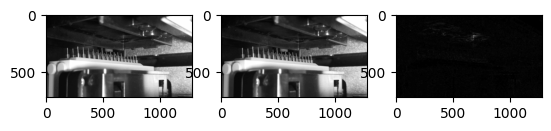

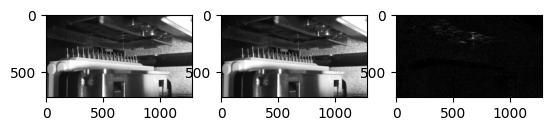

In [110]:
# use matplotlib to show the differences between the frames, as well as the two frames themselves as subplots
print("Trimmed:")
for i in range(1, trimmed_video.shape[-1], 50):
    frame1 = trimmed_video[..., i - 1]
    frame2 = trimmed_video[..., i]
    diff = np.abs(frame1 - frame2)
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(frame1, cmap='gray')
    axs[1].imshow(frame2, cmap='gray')
    axs[2].imshow(diff, cmap='gray')
    plt.show()

In [111]:
def find_total_change(video: np.ndarray, threshold: float) -> np.ndarray:
    """ 
    Finds the change in pixel intensity between frames in a video.
    
    Args:
        video: An n x m x a numpy array of the video file.
        threshold: The threshold for a significant change.
        
    Returns:
        An n x m numpy array of the heat map of the pixel intensity changes over the entire video."""
    change = np.zeros(video.shape[:2])
    for i in range(1, video.shape[-1]):
        frame_change = np.abs(video[..., i] - video[..., i-1])
        frame_change[frame_change < threshold] = 0
        change += frame_change
    return change

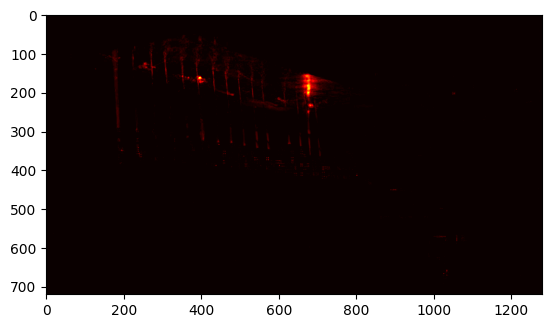

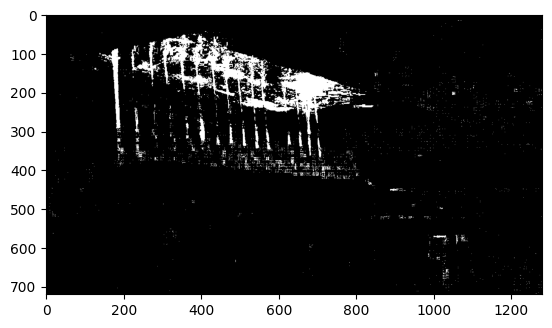

In [112]:
import matplotlib.pyplot as plt

def display_change(change: np.ndarray) -> None:
    """ 
    Displays the change in pixel intensity between frames in a video.
    
    Args:
        change: A numpy array of the pixel intensity changes between frames."""
    plt.imshow(change, cmap='hot')
    plt.show()

def display_nonzero_pixels(image: np.ndarray) -> None:
    """ 
    Sets the brightness of any pixel that is not zero to 1 and displays the image.
    
    Args:
        image: A numpy array of the image."""
    image[image != 0] = 1
    plt.imshow(image, cmap='gray')
    plt.show()
    
    
change = find_total_change(trimmed_video, 12)
display_change(change)
display_nonzero_pixels(change)